In [81]:
import os
import torch
import pandas as pd
import numpy as np
import albumentations as albu
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from torchvision.models import efficientnet

import pytorch_lightning as pl
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

from sklearn.model_selection import KFold
from metric import score

import cv2



# Configuration

In [24]:
class config:
    
    # == global config ==
    SEED = 2024  # random seed
    DEVICE = 'cuda'  # device to be used
    MIXED_PRECISION = False  # whether to use mixed-16 precision
    OUTPUT_DIR = '.'  # output folder
    
    # == data config ==
    DATA_ROOT = '/home/ybouaouni/workspace/Training/CLEF/data/bird-clef-2024'  # root folder
    PREPROCESSED_DATA_ROOT = '/home/ybouaouni/workspace/Training/CLEF/data/bird-clef-2024-5s-mel'
    LOAD_DATA = True  # whether to load data from pre-processed dataset
    FS = 32000  # sample rate
    N_FFT = 1095  # n FFT of Spec.
    WIN_SIZE = 412  # WIN_SIZE of Spec.
    WIN_LAP = 100  # overlap of Spec.
    MIN_FREQ = 40  # min frequency
    MAX_FREQ = 15000  # max frequency
    
    # == model config ==
    MODEL_TYPE = 'efficientnet_b0'  # model type
    
    # == dataset config ==
    BATCH_SIZE = 32  # batch size of each step
    N_WORKERS = 4  # number of workers
    
    # == AUG ==
    USE_XYMASKING = True  # whether use XYMasking
    
    # == training config ==
    FOLDS = 10  # n fold
    EPOCHS = 15  # max epochs
    LR = 1e-3  # learning rate
    WEIGHT_DECAY = 1e-5  # weight decay of optimizer
    
    # == other config ==
    VISUALIZE = True  # whether to visualize data and batch
    
print('fix seed')
pl.seed_everything(config.SEED, workers=True)

Seed set to 2024


fix seed


2024

In [7]:
# labels
label_list = sorted(os.listdir(os.path.join(config.DATA_ROOT, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


In [13]:
metadata_df = pd.read_csv(f'{config.DATA_ROOT}/train_metadata.csv')

In [36]:
train_df = metadata_df[['primary_label', 'rating', 'filename']].copy()

# create target
train_df['target'] = train_df.primary_label.map(label2id)
# create filepath
train_df['filepath'] = config.PREPROCESSED_DATA_ROOT + '/train_audio/' + train_df.filename.str.replace('ogg', 'npy')
# create new sample name
train_df['samplename'] = train_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

print(f'find {len(train_df)} samples')

train_df.head(3)

find 24459 samples


,primary_label,rating,filename,target,filepath,samplename
0,asbfly,5.0,asbfly/XC134896.ogg,0,/home/ybouaouni/workspace/Training/CLEF/data/b...,asbfly-XC134896
1,asbfly,2.5,asbfly/XC164848.ogg,0,/home/ybouaouni/workspace/Training/CLEF/data/b...,asbfly-XC164848
2,asbfly,2.5,asbfly/XC175797.ogg,0,/home/ybouaouni/workspace/Training/CLEF/data/b...,asbfly-XC175797


In [39]:
import pandas as pd
import numpy as np

def load_data_as_dict(df, filepath_column, samplename_column):
    """
    Loads data from file paths in a dataframe into a dictionary.

    Parameters:
    - df: pandas DataFrame containing file paths and sample names
    - filepath_column: name of the column containing file paths
    - samplename_column: name of the column containing sample names

    Returns:
    - data_dict: dictionary where keys are sample names and values are numpy arrays loaded from file paths
    """
    data_dict = {}

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading Data"):
        filepath = row[filepath_column]
        samplename = row[samplename_column]
        array_data = np.load(filepath)
        data_dict[samplename] = array_data

    return data_dict


In [40]:
if config.LOAD_DATA:
    print('load from file')
    all_bird_data = load_data_as_dict(train_df, 'filepath', 'samplename')

load from file


Loading Data: 100%|██████████| 24459/24459 [06:20<00:00, 64.30it/s] 


In [82]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        metadata,
        augmentation=None,
        mode='train'
    ):
        super().__init__()
        self.metadata = metadata
        self.augmentation = augmentation
        self.mode = mode
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        
        row_metadata = self.metadata.iloc[index]
        
        # load spec. data
        input_spec = all_bird_data[row_metadata.samplename]
        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)
        
        # aug
        if self.augmentation is not None:
            input_spec = self.augmentation(image=input_spec)['image']
        
        # target
        target = row_metadata.target
        
        return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long)

In [44]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
            albu.HorizontalFlip(0.5),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 3),
                num_masks_y=(1, 3),
                mask_x_length=(1, 10),
                mask_y_length=(1, 20),
            )
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [49]:
import sys

memory_used_mb = sys.getsizeof(all_bird_data) / (1024 ** 2)
print("Memory used by the dictionary:", memory_used_mb, "MB")


Memory used by the dictionary: 0.916748046875 MB


(128, 313)


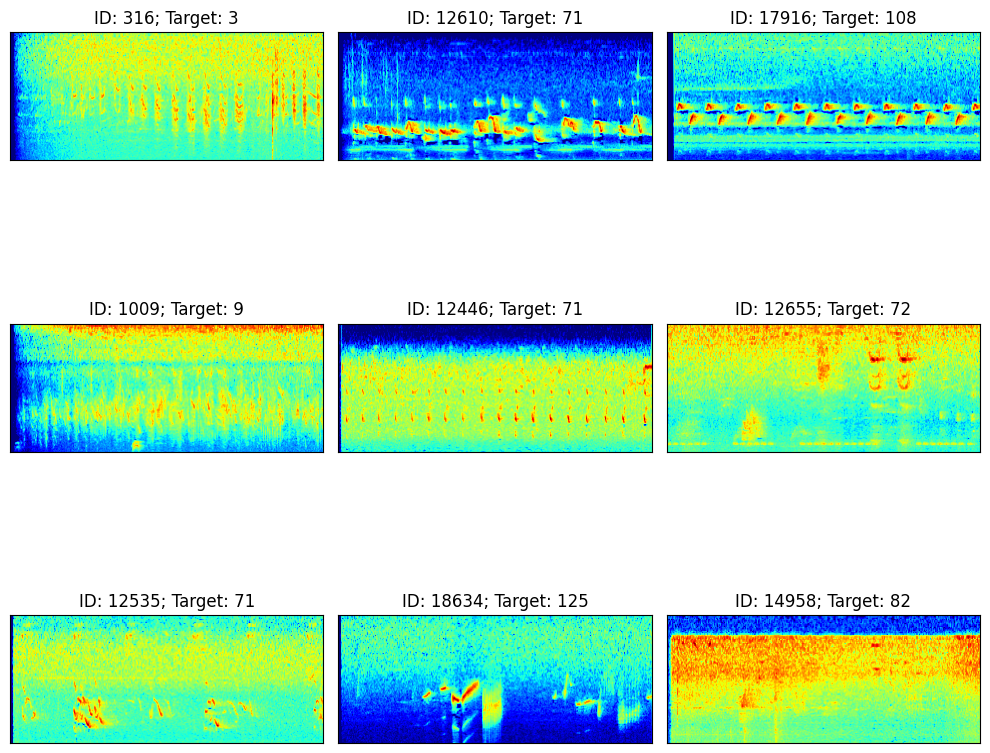

15293

In [47]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label}')
    
    plt.tight_layout()
    plt.show()
    
dummy_dataset = BirdDataset(train_df, None)

test_input, test_target = dummy_dataset[0]
print(test_input.detach().numpy().shape)

if config.VISUALIZE:
    show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

In [52]:
class EffNet(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=True):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')
        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        return self.base_model(x)

In [53]:
dummy_model = EffNet(config.MODEL_TYPE, n_classes=len(label_list))

dummy_input = torch.randn(2, 256, 256)
print(dummy_model(dummy_input).shape)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/ybouaouni/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 90.1MB/s]


torch.Size([2, 182])


In [72]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(config.MODEL_TYPE, n_classes=len(label_list))
        
        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=config.EPOCHS,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

In [65]:
def predict(data_loader, model):
    model.to(config.DEVICE)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
    gts = torch.nn.functional.one_hot(gts, len(label_list))
    
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [83]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df['fold'] != fold_id].copy()
    valid_df = total_df[total_df['fold'] == fold_id].copy()
    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')
    
    #train_ds = BirdDataset(train_df, get_transforms('train'), 'train')
    #val_ds = BirdDataset(valid_df, get_transforms('valid'), 'valid')

    train_ds = BirdDataset(train_df, None, 'train')
    val_ds = BirdDataset(valid_df, None, 'valid')
     
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=config.BATCH_SIZE * 2,
        shuffle=False,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel()
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=config.OUTPUT_DIR,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=config.EPOCHS,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if config.MIXED_PRECISION else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{config.OUTPUT_DIR}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score

In [84]:
kf = KFold(n_splits=config.FOLDS, shuffle=True, random_state=config.SEED)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    train_df.loc[val_idx, 'fold'] = fold

In [85]:
# training
torch.set_float32_matmul_precision('high')

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(config.FOLDS):
    
    # get validation index
    val_idx = list(train_df[train_df['fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)
    
    # only training one fold
    break


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')


oof_df.to_csv(f"{config.OUTPUT_DIR}/oof_pred.csv", index=False)

==== Running training for fold 0 ====
Train Samples: 22013
Valid Samples: 2446


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


PermissionError: [Errno 13] Permission denied: '/kaggle'